## Imports & Setup

In [2]:
import sys
import yaml
import shutil
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Add the scripts directory to system path so we can import our modules
# Assumes notebook is in /notebooks and scripts are in /scripts
current_dir = Path.cwd()
sys.path.append(str(current_dir.parent / "scripts"))

# Import our custom robust modules
from project_paths import ROOT_DIR, CONFIG_DIR, DATA_DIR, resolve_path
import model_builder

print(f"✅ Project Root: {ROOT_DIR}")
print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ Devices: {tf.config.list_physical_devices()}")

✅ Project Root: /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526
✅ TensorFlow Version: 2.20.0
✅ Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Experiment Manager

In [3]:
def setup_experiment(config, config_source_path):
    """
    Creates a unique run directory and backs up the config.
    Returns: run_dir (Path), log_dir (Path), checkpoint_path (Path)
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = config['project']['run_name']
    
    # Create runs/YYYYMMDD_HHMMSS_run_name
    run_dir = ROOT_DIR / "runs" / f"{run_name}_{timestamp}"
    run_dir.mkdir(parents=True, exist_ok=True)
    
    # Create subdirectories
    log_dir = run_dir / "logs"
    log_dir.mkdir(exist_ok=True)
    
    checkpoint_dir = run_dir / "checkpoints"
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Backup the config file
    shutil.copy(config_source_path, run_dir / "config.yaml")
        
    print(f"🚀 Experiment initialized at: {run_dir}")
    return run_dir, log_dir, checkpoint_dir

# Load the config
config_path = CONFIG_DIR / "model_config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Setup the run
run_dir, log_dir, checkpoint_dir = setup_experiment(config, config_path)

🚀 Experiment initialized at: /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/run_06_dataset_improvements_metrics_20260109_202000


## Data Loading Pipeline

In [4]:
# Resolve the dataset path using our helper (handles absolute/relative)
dataset_path = resolve_path(config['data']['dataset_path'])

img_size = (config['data']['img_height'], config['data']['img_width'])
batch_size = config['data']['batch_size']
color_mode = 'grayscale' if config['data']['channels'] == 1 else 'rgb'

print(f"📂 Loading data from: {dataset_path}")

# 1. Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=config['data']['validation_split'],
    subset="training",
    seed=config['project']['seed'],
    image_size=img_size,
    batch_size=batch_size,
    color_mode=color_mode
)

# 2. Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=config['data']['validation_split'],
    subset="validation",
    seed=config['project']['seed'],
    image_size=img_size,
    batch_size=batch_size,
    color_mode=color_mode
)

# 3. Performance Optimization (The "Secret Sauce" for speed)
# cache() keeps images in memory after the first epoch
# prefetch() prepares the next batch while the GPU/CPU is working
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Data Pipeline Ready")

📂 Loading data from: /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/data/processed_patches
Found 40000 files belonging to 2 classes.
Using 32000 files for training.


I0000 00:00:1767986418.045099   72148 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5816 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:29:00.0, compute capability: 7.5


Found 40000 files belonging to 2 classes.
Using 8000 files for validation.
✅ Data Pipeline Ready


## Build & Compile the Model

In [5]:
# Build the model dynamically from the config
model = model_builder.build_model_from_config(config)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 256, 256, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 914,177 (3.49 MB)

 Trainable params: 913,217 (3.48 MB)

 Non-trainable params: 960 (3.75 KB)

## Callbacks and Training

In [6]:
# Define Callbacks
callbacks = [
    # Stop if validation loss doesn't improve for 'patience' epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['train']['callbacks']['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    # Save the best model to the run folder
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(checkpoint_dir / "best_model.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Log metrics for visualization
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    
    # Save CSV logs for easy plotting later
    tf.keras.callbacks.CSVLogger(str(run_dir / "training_log.csv"))
]

# --- NEW: Add Scheduler if enabled in config ---
if config['train']['callbacks'].get('use_lr_scheduler', False):
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=config['train']['callbacks']['reduce_lr_factor'],
        patience=config['train']['callbacks']['reduce_lr_patience'],
        min_lr=config['train']['callbacks']['reduce_lr_min'],
        verbose=1  # It will print "Reducing learning rate to..."
    )
    callbacks.append(scheduler)
    print("✅ Learning Rate Scheduler: ENABLED")

# START TRAINING
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['train']['epochs'],
    callbacks=callbacks
)

# Save the final model just in case
model.save(run_dir / "final_model.keras")
print("🏁 Training Complete!")

✅ Learning Rate Scheduler: ENABLED
Epoch 1/50


2026-01-09 20:20:48.557398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 257 of 1000
2026-01-09 20:20:50.147217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2026-01-09 20:20:51.547776: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - Precision: 0.7575 - Recall: 0.6984 - accuracy: 0.7350 - loss: 0.5766
Epoch 1: val_loss improved from None to 1.04457, saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/run_06_dataset_improvements_metrics_20260109_202000/checkpoints/best_model.keras

Epoch 1: finished saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/run_06_dataset_improvements_metrics_20260109_202000/checkpoints/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 200ms/step - Precision: 0.8207 - Recall: 0.7264 - accuracy: 0.7834 - loss: 0.4712 - val_Precision: 0.5516 - val_Recall: 0.9081 - val_accuracy: 0.5879 - val_loss: 1.0446 - learning_rate: 5.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - Precision: 0.8923 - Recall: 0.7848 - accuracy: 0.8444 - loss: 0.3590
Epoch 2: val_loss improved from 1.04457 to 0.45187, saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs

## Visualization

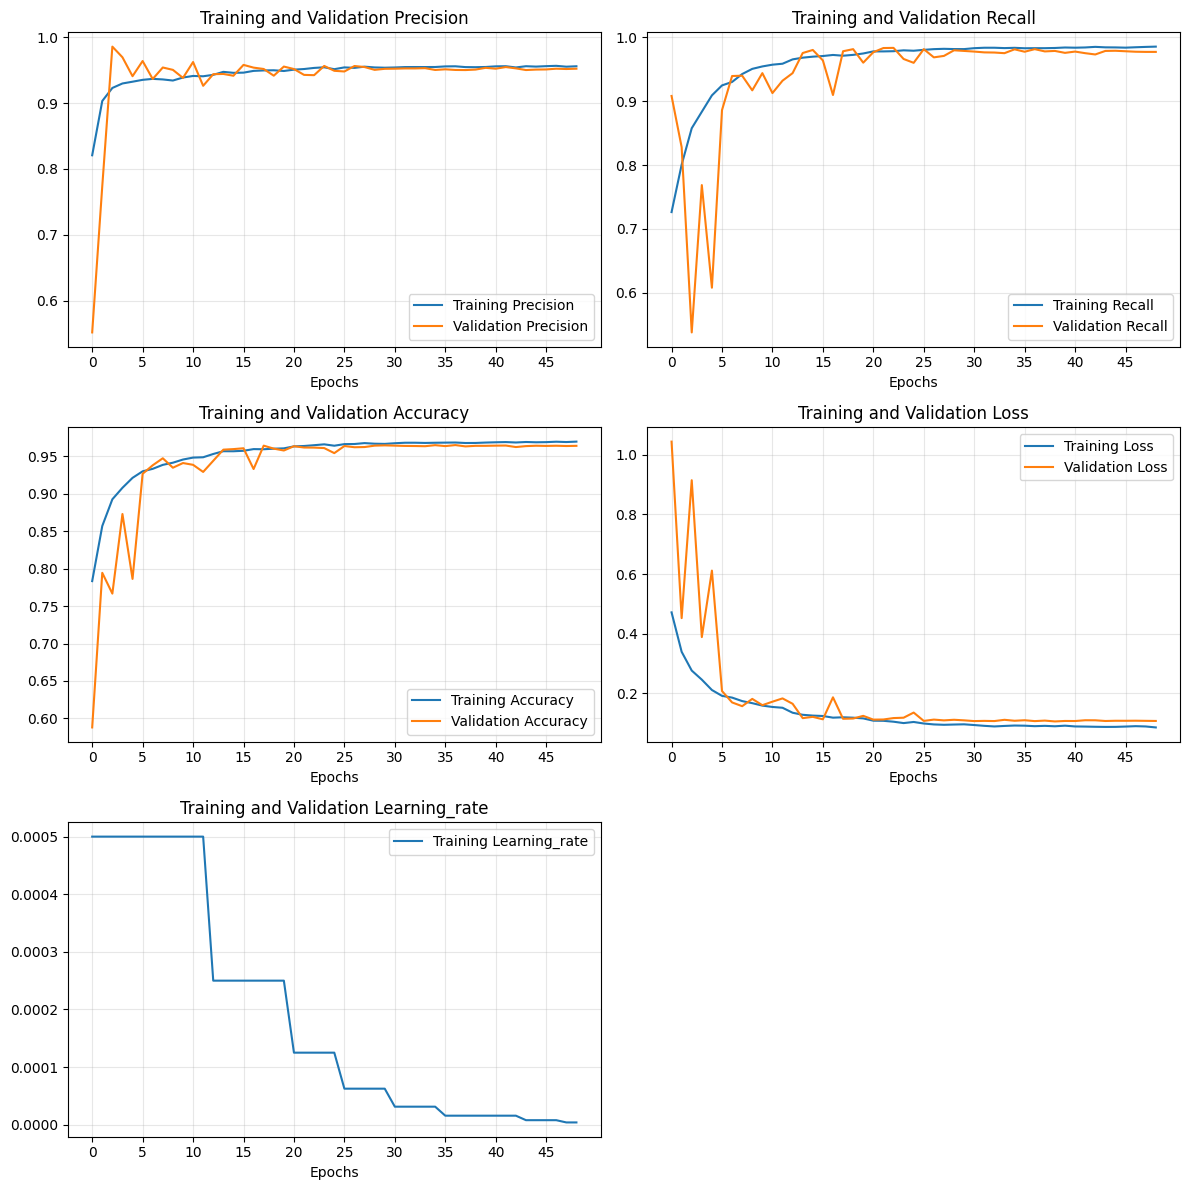

In [7]:
import math

def plot_history(history):
    # 1. Identify unique base metrics (ignore 'val_' prefix)
    # We filter keys to find the "training" versions (e.g., 'loss', 'accuracy', 'precision')
    all_keys = history.history.keys()
    base_metrics = [k for k in all_keys if not k.startswith('val_')]
    
    # 2. Determine Grid Size
    n_metrics = len(base_metrics)
    n_cols = 2  # Two plots per row looks best
    n_rows = math.ceil(n_metrics / n_cols)
    
    # 3. Create Figure
    # Scale height based on number of rows
    plt.figure(figsize=(12, 4 * n_rows))
    
    epochs_range = range(len(history.history[base_metrics[0]]))

    for i, metric in enumerate(base_metrics):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot Training Metric
        plt.plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        
        # Plot Validation Metric (if it exists)
        val_key = f"val_{metric}"
        if val_key in all_keys:
            plt.plot(epochs_range, history.history[val_key], label=f'Validation {metric.capitalize()}')
            
        plt.legend(loc='best')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        
        # Only show grid and ticks for cleaner look
        plt.grid(True, alpha=0.3)
        # Reduce x-ticks density if many epochs
        if len(epochs_range) > 20:
             plt.xticks(epochs_range[::5]) # Show every 5th epoch
        else:
             plt.xticks(epochs_range[::2])

    plt.tight_layout()
    plt.show()

# Usage
plot_history(history)